Code for analyzing basic sequence embedding through excitability changes in leaky integrate-and-fire networks.

In [1]:
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic, GenericFlexible
from ntwk import LIFNtwk
from disp import raster, set_font_size

import _1A

In [2]:
SEED = 0

L = 5  # max seq len
E_L_1 = -0.05  # hyperexcitable voltage (V)
SEED_CHAIN = 1  # RNG seed for choosing example chain

N = 100  # num nrns
FRQ_UP = 429  # upstream stim freq (Hz)

Q = 0.1  # cxn density

GAMMA = 1.3141  # SF power-law coef

W_E_UP = 0.01  # upstream syn. weight
W_E_RCR = 0.00735  # rcr syn. weight

T_M = 0.05  # membrane time const (s)
E_L = -0.068  # membrane leak potential (V)
V_TH = -0.036  # spike threshold (V)
V_RESET = -0.068  # reset potential (V)
T_R = 0.002  # refrac per. (s)

E_E = 0  # exc syn. rev. potential (V)
T_E = 0.002  # exc syn time const (s)

DUR = 5  # smln dur
T_START = 0.5  # analysis start time
DT = 0.0005  # smln time step

MAX_ITER = 100000  # number of times to attempt to find nrn chain

# derived grouped params

## sf ntwk
P_SF = GenericFlexible(
    # ntwk
    gamma=GAMMA, n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_rcr=W_E_RCR, w_e_up=W_E_UP,
    
    # input & smln
    frq_up=FRQ_UP,
    dt=DT, dur=DUR, t_start=T_START, seed=SEED,)

# Check EPSP induced by excitatory cxn weight

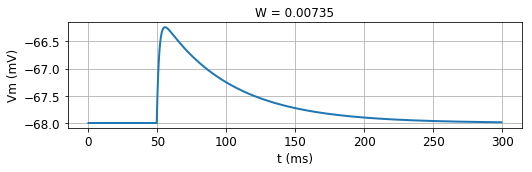

In [3]:
# skip
ntwk_epsp = LIFNtwk(
    t_m=np.array([T_M]),
    e_l=np.array([E_L]),
    v_th=np.array([V_TH]),
    v_reset=np.array([V_RESET]),
    t_r=np.array([T_R]),
    es_syn={'E': E_E},
    ts_syn={'E': T_E},
    ws_rcr={'E': np.array([[0.]])},
    ws_up={'E': np.array([[W_E_RCR]])})

t = np.arange(0, 0.3, DT)
spks_up = np.zeros((len(t), 1))
spks_up[int(0.05/DT), 0] = 1

rsp = ntwk_epsp.run(spks_up=spks_up, dt=DT)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5/3), tight_layout=True)
ax.plot(1000 * t, 1000 * rsp.vs[:, 0], lw=2)
ax.grid()
ax.set_xlabel('t (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('W = {}'.format(W_E_RCR))
set_font_size(ax, 12)

# Test baseline ntwk

In [4]:
# make ntwk
STORE = GenericFlexible()
ntwk_0 = _1A.sf_ntwk(P_SF, STORE)[0]

# make equiv. unc ntwk
ntwk_unc = deepcopy(ntwk_0)
ntwk_unc.ws_rcr['E'][:] = 0

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:
# make frozen noise stim
np.random.seed(P_SF.seed)

t = np.arange(0, P_SF.dur, P_SF.dt)
spks_up = np.random.poisson(P_SF.frq_up * P_SF.dt, (len(t), P_SF.n))

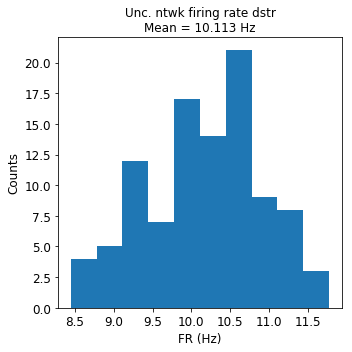

In [6]:
# drive unc ntwk
rsp_unc = ntwk_unc.run(spks_up, P_SF.dt)

# plot firing rates
t_mask = (P_SF.t_start <= rsp_unc.ts)
fr_unc = rsp_unc.spks[t_mask, :].sum(0) / (P_SF.dur - P_SF.t_start)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ax.hist(fr_unc)
ax.set_xlabel('FR (Hz)')
ax.set_ylabel('Counts')
ax.set_title('Unc. ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_unc.mean()))

set_font_size(ax, 12)

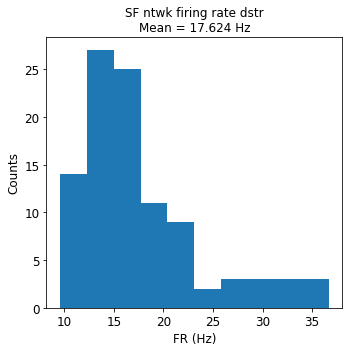

In [7]:
# drive sf ntwk
rsp_0 = ntwk_0.run(spks_up, P_SF.dt)

# plot firing rates
t_mask = (P_SF.t_start <= rsp_0.ts)
fr_0 = rsp_0.spks[t_mask, :].sum(0) / (P_SF.dur - P_SF.t_start)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ax.hist(fr_0)
ax.set_xlabel('FR (Hz)')
ax.set_ylabel('Counts')
ax.set_title('SF ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_0.mean()))

set_font_size(ax, 12)

# Identify cell chain to make hyperexcitable

In [8]:
np.random.seed(SEED+1)

adj = np.array((rsp_0.ws_rcr['E'] > 0).todense())

chain = []

for ctr in range(MAX_ITER):
    
    if not chain:
        # choose from all nrns
        idxs = np.arange(P_SF.n)
    else:
        # choose from nrns downstream of lsat nrn
        idxs = adj[:, chain[-1]].nonzero()[0]
    
    if len(idxs) == 0:
        # start new chain
        chain = []
    else:
        # select random nrn to append to chain
        nrn = np.random.choice(idxs)
        chain.append(nrn)
        
    if len(chain) >= L:
        break
        
else:
    raise Exception('Could not find connected chain')
    
# show cxns among selected nrns
print('Connectivity among hyper exc. nrns (row: to, col:from)')
print(adj[chain, :][:, chain].astype(int))

Connectivity among hyper exc. nrns (row: to, col:from)
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


# Drive ntwk that includes hyperexcitable chain

## Make copy of baseline ntwk and increase E_L for chain nrns

In [9]:
ntwk_1 = deepcopy(ntwk_0)

ntwk_1.e_l[chain] = E_L_1
ntwk_1.v_reset[chain] = E_L_1

## Drive with same noise as baseline ntwk

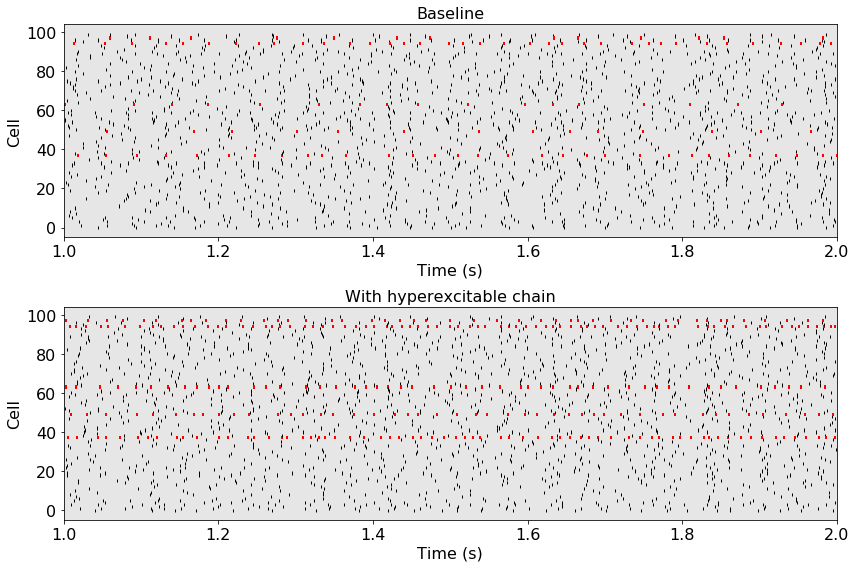

In [10]:
rsp_1 = ntwk_1.run(spks_up, P_SF.dt)

# plot rasters
fig, axs = plt.subplots(2, 1, figsize=(12, 8), tight_layout=True)

## get idxs of hyperexcitable nrn spikes to assign colors/lws
spk_nrns_0 = rsp_0.spks.nonzero()[1]
spk_nrns_1 = rsp_1.spks.nonzero()[1]

### baseline
c_0 = np.repeat('k', len(spk_nrns_0))
c_1 = np.repeat('k', len(spk_nrns_1))

lw_0 = np.repeat(1, len(spk_nrns_0))
lw_1 = np.repeat(1, len(spk_nrns_1))

### color hyperexc.
for nrn in chain:
    c_0[spk_nrns_0 == nrn] = 'r'
    c_1[spk_nrns_1 == nrn] = 'r'
    
    lw_0[spk_nrns_0 == nrn] = 2
    lw_1[spk_nrns_1 == nrn] = 2

## make rasters
    
raster(axs[0], rsp_0.ts, rsp_0.spks, c=c_0, lw=lw_0)
raster(axs[1], rsp_1.ts, rsp_1.spks, c=c_1, lw=lw_1)

for ax in axs:
    ax.set_xlim(1, 2)

axs[0].set_title('Baseline')
axs[1].set_title('With hyperexcitable chain')

for ax in axs:
    ax.set_facecolor((.9, .9, .9))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cell')
    set_font_size(ax, 16)

## Plot of just hyperexcitable cells

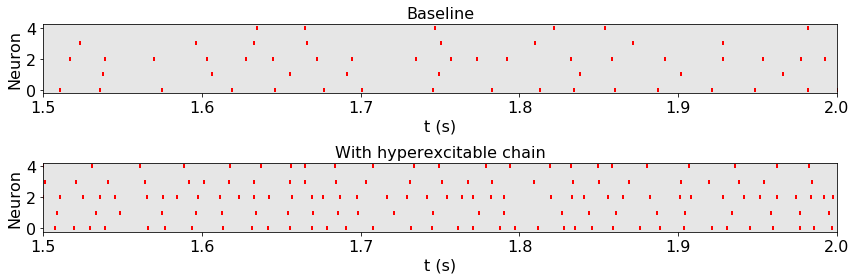

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 4), tight_layout=True)

raster(axs[0], rsp_0.ts, rsp_0.spks[:, chain], c='r', lw=2)
raster(axs[1], rsp_1.ts, rsp_1.spks[:, chain], c='r', lw=2)

for ax in axs:
    ax.set_xlim(1.5, 2)
    
axs[0].set_title('Baseline')
axs[1].set_title('With hyperexcitable chain')

for ax in axs:
    ax.set_facecolor((.9, .9, .9))
    set_font_size(ax, 16)

# Analyze sequences

## Define seq-counting func

In [12]:
def ct_seq(spks):
    """Count ordered seqs in multi-cell spk train.
    
    :return: number of ordered seqs for each seq length up to num cells in spk train
    :return: total number of seqs of each seq length
    """
    cts_ordered = []
    cts_total = []
    
    # get cell idxs of spks
    nrns = spks.nonzero()[1]
    
    # loop over seq lens
    for l in range(2, spks.shape[1] + 1):
        
        ct_ordered = 0
        ct_total = 0
        
        # loop over all spk seqs
        for s_ctr in range(len(nrns) - l + 1):
            seq = nrns[s_ctr:s_ctr+l]
            
            # check if ordered
            if list(seq) == list(range(min(seq), max(seq)+1)):
                ct_ordered += 1
                
            ct_total += 1
        
        cts_ordered.append(ct_ordered)
        cts_total.append(ct_total)
        
    return np.array(cts_ordered), np.array(cts_total)

## Test seq-counting func

In [13]:
def test_ct_seq():
    
    spks = np.array([
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ])

    cts_ordered_desired = np.array([7, 5, 3, 1])
    cts_total_desired = np.array([13, 12, 11, 10])
    
    cts_ordered_actual, cts_total_actual = ct_seq(spks)
    
    np.testing.assert_array_equal(cts_ordered_actual, cts_ordered_desired)
    np.testing.assert_array_equal(cts_total_actual, cts_total_desired)
    
    print('cts_ordered_actual: {}'.format(cts_ordered_actual))
    print('cts_ordered_desired: {}\n'.format(cts_ordered_desired))
    
    print('cts_total_actual: {}'.format(cts_total_actual))
    print('cts_total_desired: {}\n'.format(cts_total_desired))
    
    print('Test passed.')

test_ct_seq()

cts_ordered_actual: [7 5 3 1]
cts_ordered_desired: [7 5 3 1]

cts_total_actual: [13 12 11 10]
cts_total_desired: [13 12 11 10]

Test passed.


## Count seqs in baseline vs hyperexc-chain ntwk response

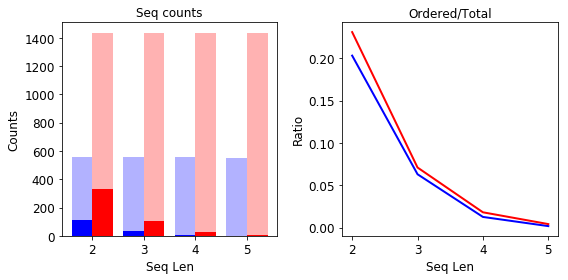

In [14]:
# count ordered and total sequences in each multi-cell spike train
cts_ordered_0, cts_total_0 = ct_seq(rsp_0.spks[:, chain])
cts_ordered_1, cts_total_1 = ct_seq(rsp_1.spks[:, chain])

ratio_0 = cts_ordered_0/cts_total_0
ratio_1 = cts_ordered_1/cts_total_1

fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

x = np.arange(2, L+1)

axs[0].bar(x, cts_total_0, align='edge', width=-0.4, color='b', alpha=0.3)
axs[0].bar(x, cts_ordered_0, align='edge', width=-0.4, color='b', alpha=1)

axs[0].bar(x, cts_total_1, align='edge', width=0.4, color='r', alpha=0.3)
axs[0].bar(x, cts_ordered_1, align='edge', width=0.4, color='r', alpha=1)

axs[0].set_ylabel('Counts')
axs[0].set_title('Seq counts')

axs[1].plot(x, ratio_0, color='b', lw=2)
axs[1].plot(x, ratio_1, color='r', lw=2)

axs[1].set_ylabel('Ratio')
axs[1].set_title('Ordered/Total')

for ax in axs:
    ax.set_xticks(x)
    ax.set_xlabel('Seq Len')
    set_font_size(ax, 12)